# Collaboration Analysis

## Set up and Processing 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import src.utils.data_utils as data_utils
import src.utils.Collaborations_utils as collab_utils

# Statistical tests
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
from scipy.stats import cramervonmises_2samp

# Check if LaTeX is available, if not we don't import the plot_config module
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

latex_available = False
try:
    plt.rcParams['text.usetex'] = True
    plt.text(0, 0, "Test", fontsize=12)
    latex_available = True
    plt.close()
except Exception as e:
    print("LaTeX is not available. Error:", e)
finally:
    plt.rcParams['text.usetex'] = False

# Import the plot_config module if LaTeX is available
if latex_available:
    import src.utils.plot_config

%matplotlib inline

In [2]:
# Download the data files
datasets = [
    # ("https://zenodo.org/records/4650046/files/_raw_df_channels.tsv.gz?download=1", "channels.tsv.gz"), # 6.0 MB
    # ("https://zenodo.org/records/4650046/files/yt_metadata_en.jsonl.gz?download=1", "yt_metadata.jsonl.gz"), # 13.6 GB
]

data_utils.get_data(datasets)

In [3]:
# Only keep Music and Entertainment Videos
chunk_size = 500_000
# data_utils.process_data(file_path='data/yt_metadata.jsonl.gz',
#                         chunk_size=chunk_size,
#                         preprocess_func=data_utils.filter_categories,
#                         output_path='data/yt_metadata_filtered.jsonl.gz')

Now that we have a smaller dataset, we create a new file `views.jsonl.gz`. It contains all the entries of the `yt_metadata_filtered.jsonl.gz` dataset. I.e. each entry represents a video, and we only keep columns corresponding to:  
- the video id
- the category
- the number of views

This will be useful to reduce the size of our dataset. The method is the following: for each category, we only *keep the most viewed videos that contribute to a fraction $p$ of the total number of views of the category*.

In [4]:
# process_views(file_path="data/yt_metadata_filtered.jsonl.gz",
#               output_path="data/views.jsonl.gz",
#               chunk_size=chunk_size)

In [ ]:
# Load the views data
df_views = pd.read_json("data/views.jsonl.gz", lines=True, compression="gzip")

category_map = {"Music": 0, "Entertainment": 1}
df_views_music = df_views[df_views["categories"] == category_map["Music"]]
df_views_entertainment = df_views[df_views["categories"] == category_map["Entertainment"]]

In [ ]:
# Keep only the top p% of the videos
p = 0.95
df_top_p_music = collab_utils.top_p_views(df_views_music, p)
df_top_p_entertainment = collab_utils.top_p_views(df_views_entertainment, p)

In [ ]:
# Print and plot the result of the filtering step
collab_utils.top_p_results(df_views_music, df_top_p_music, df_views_entertainment, df_top_p_entertainment, p, plot=True)

**Add comment**

## Collaboration Detection: Does Collaboration Have an Overall Beneficial Effect in Terms of Viewership, Number of Likes and Dislikes? 

### Collaboration Detection using Video Titles

In [3]:
# Load the data
top_p_music = pd.read_json("data/top_95.0_Music.jsonl.gz", lines=True, compression="gzip")

In [4]:
top_p_entertainment = pd.read_json("data/top_95.0_Entertainment.jsonl.gz", lines=True, compression="gzip")

In [5]:
# Detect collaborations and sort the data by the number of views
top_p_music["collab"] = top_p_music["title"].apply(lambda x: collab_utils.detect_collaboration(x))
top_p_entertainment["collab"] = top_p_entertainment["title"].apply(lambda x: collab_utils.detect_collaboration(x))

top_p_entertainment = top_p_entertainment.sort_values(by="view_count", ascending=False)
top_p_music = top_p_music.sort_values(by="view_count", ascending=False)

In [6]:
collab_utils.print_collab_stats(top_p_music, top_p_entertainment)

Category                       Number of Videos     Number of Collaborations       Fraction            
-------------------------------------------------------------------------------------------------------
Music                          541108               67893                          12.55%              
Entertainment                  1782414              46357                          2.60%               


### Comparison of the distribution of Views, Likes and Dislikes across Collaborations and Non-collaborations

#### Music Category

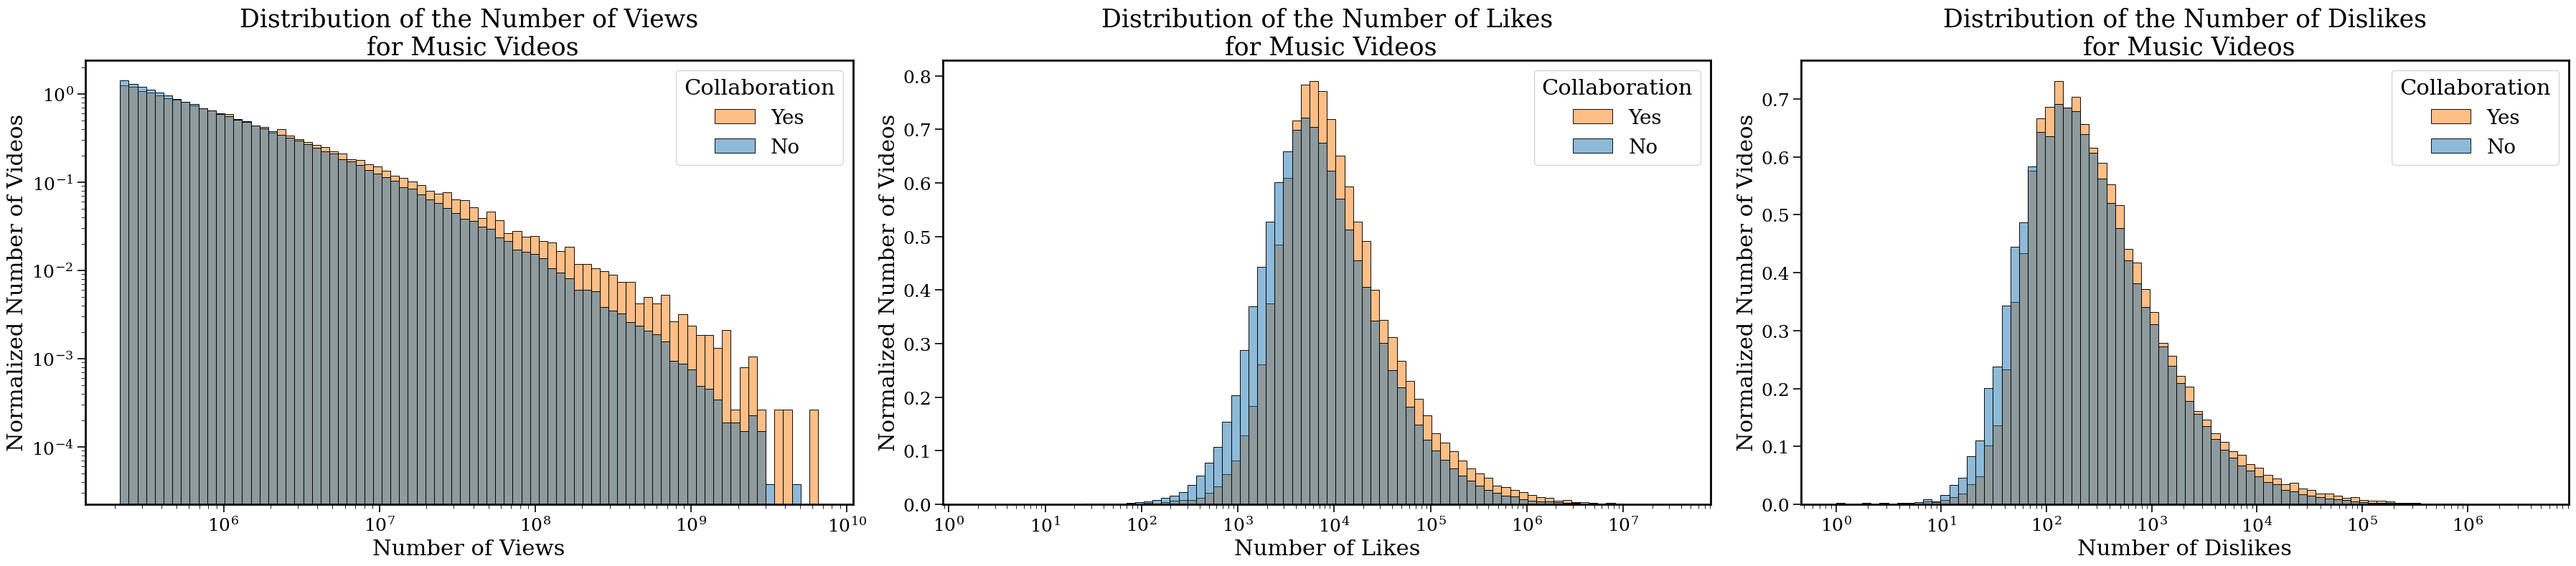

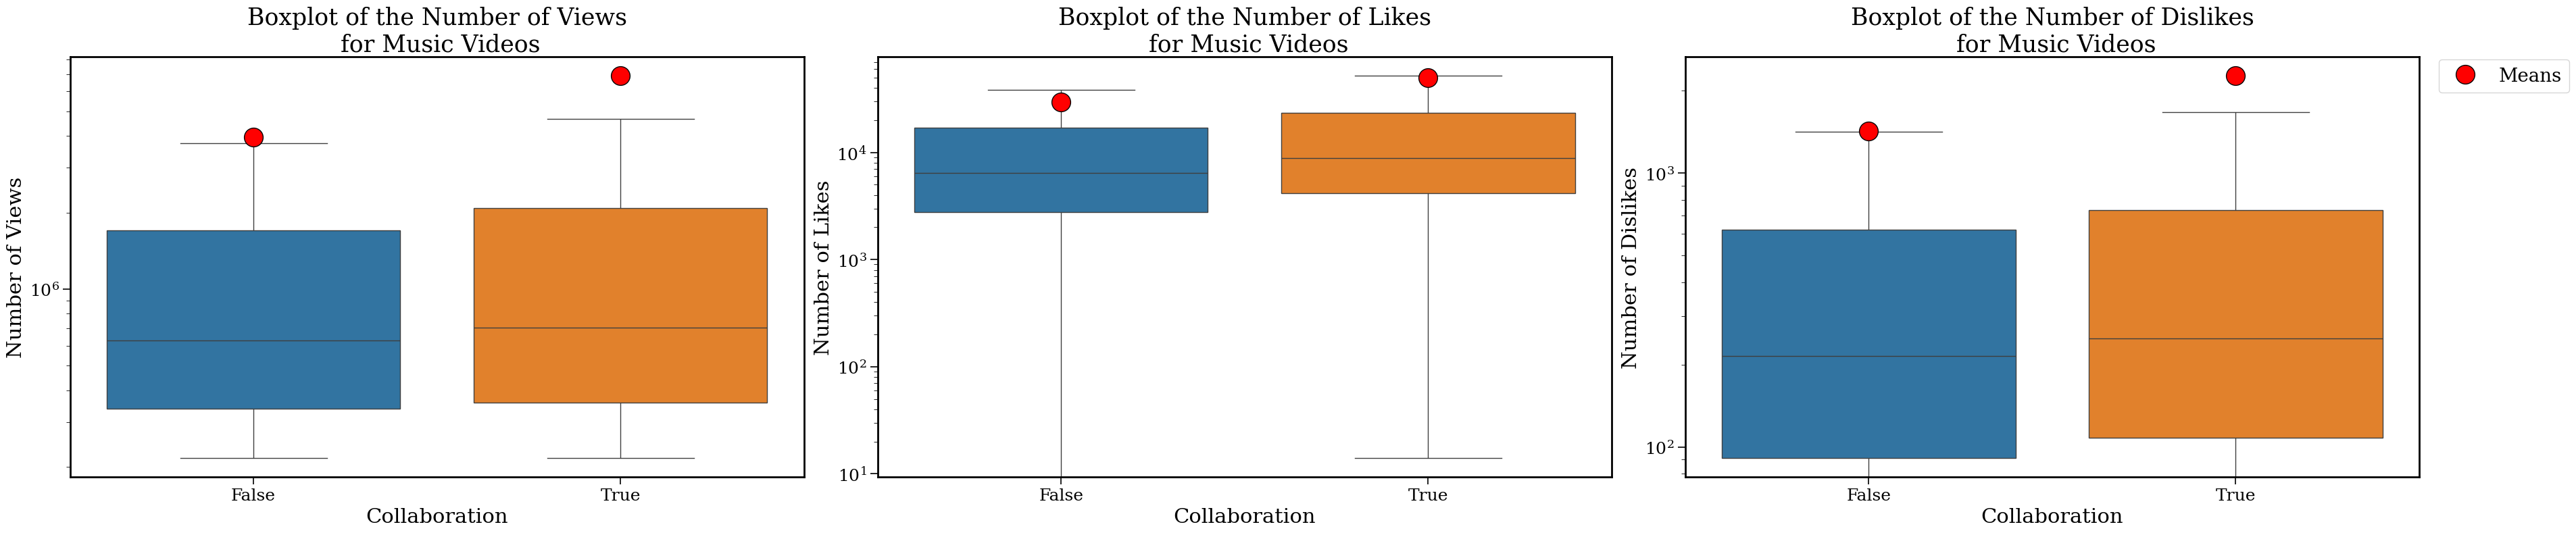

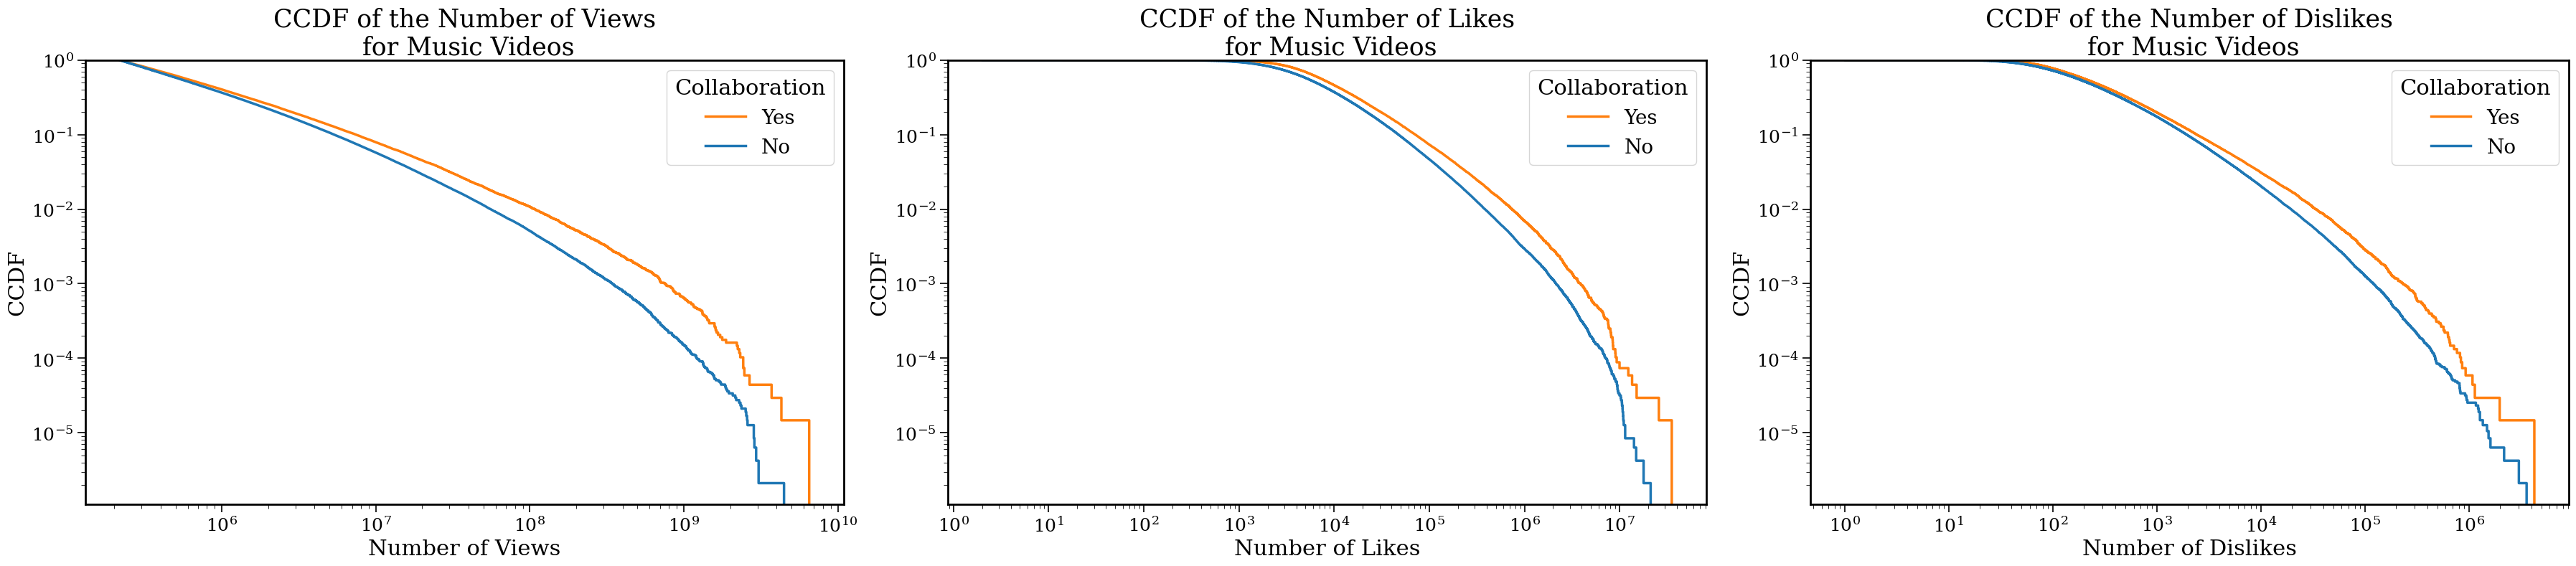

In [11]:
# Compare the different distributions between collaborations and non collaborations for the Music category
columns = ["view_count", "like_count", "dislike_count"]
custom_labels = {"view_count": "Number of Views", "like_count": "Number of Likes",
                 "dislike_count": "Number of Dislikes"}
x_logs = [True, True, True]
y_logs = [True, False, False]

collab_utils.plot_comparison_collab_and_non_collab(
    data=top_p_music,
    category="Music",
    columns=columns,
    x_logs=x_logs,
    y_logs=y_logs,
    custom_labels=custom_labels,
    save=True,
)

In [18]:
collab_utils.compare_means_collab_non_collab(top_p_music, columns, custom_labels)

╒═════════════════════════╤══════════════════╤══════════════════════╤════════════════╕
│ Metric                  │ Collaborations   │ Non-Collaborations   │   Ratio (C/NC) │
╞═════════════════════════╪══════════════════╪══════════════════════╪════════════════╡
│ Mean Number of Views    │ 6,901,665.40     │ 3,963,053.55         │           1.74 │
├─────────────────────────┼──────────────────┼──────────────────────┼────────────────┤
│ Mean Number of Likes    │ 49,664.34        │ 29,515.81            │           1.68 │
├─────────────────────────┼──────────────────┼──────────────────────┼────────────────┤
│ Mean Number of Dislikes │ 2,271.68         │ 1,423.92             │           1.6  │
╘═════════════════════════╧══════════════════╧══════════════════════╧════════════════╛


In [21]:
collab_utils.test_distributions(top_p_music, columns, custom_labels)

╒═════════════════════════════════════════╤═════════════╤═══════════╤════════════════╕
│ Test                                    │   Statistic │   P-Value │ Significant?   │
╞═════════════════════════════════════════╪═════════════╪═══════════╪════════════════╡
│ Mann-Whitney U (Number of Views)        │    1.7e+10  │ 1.06e-122 │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Kolmogorov-Smirnov (Number of Views)    │    0.0388   │ 5.36e-78  │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Cramér-von Mises (Number of Views)      │   52.72     │ 0         │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Mann-Whitney U (Number of Likes)        │    1.86e+10 │ 0         │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Kolmogorov-Smirnov (Number of Likes)    │

#### Entertainment Category

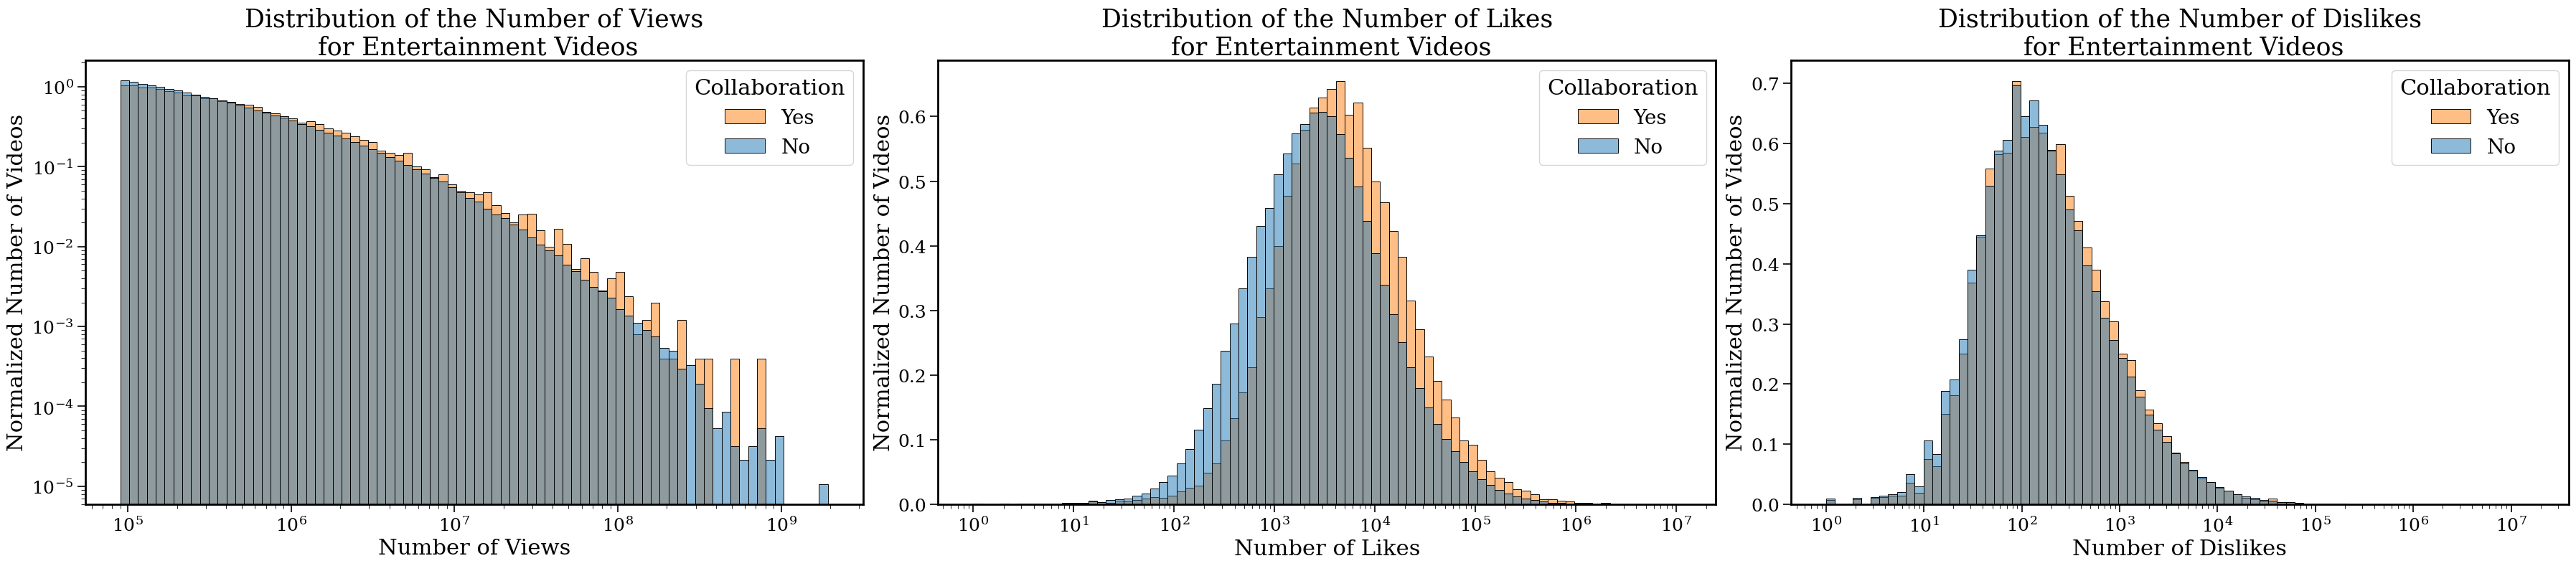

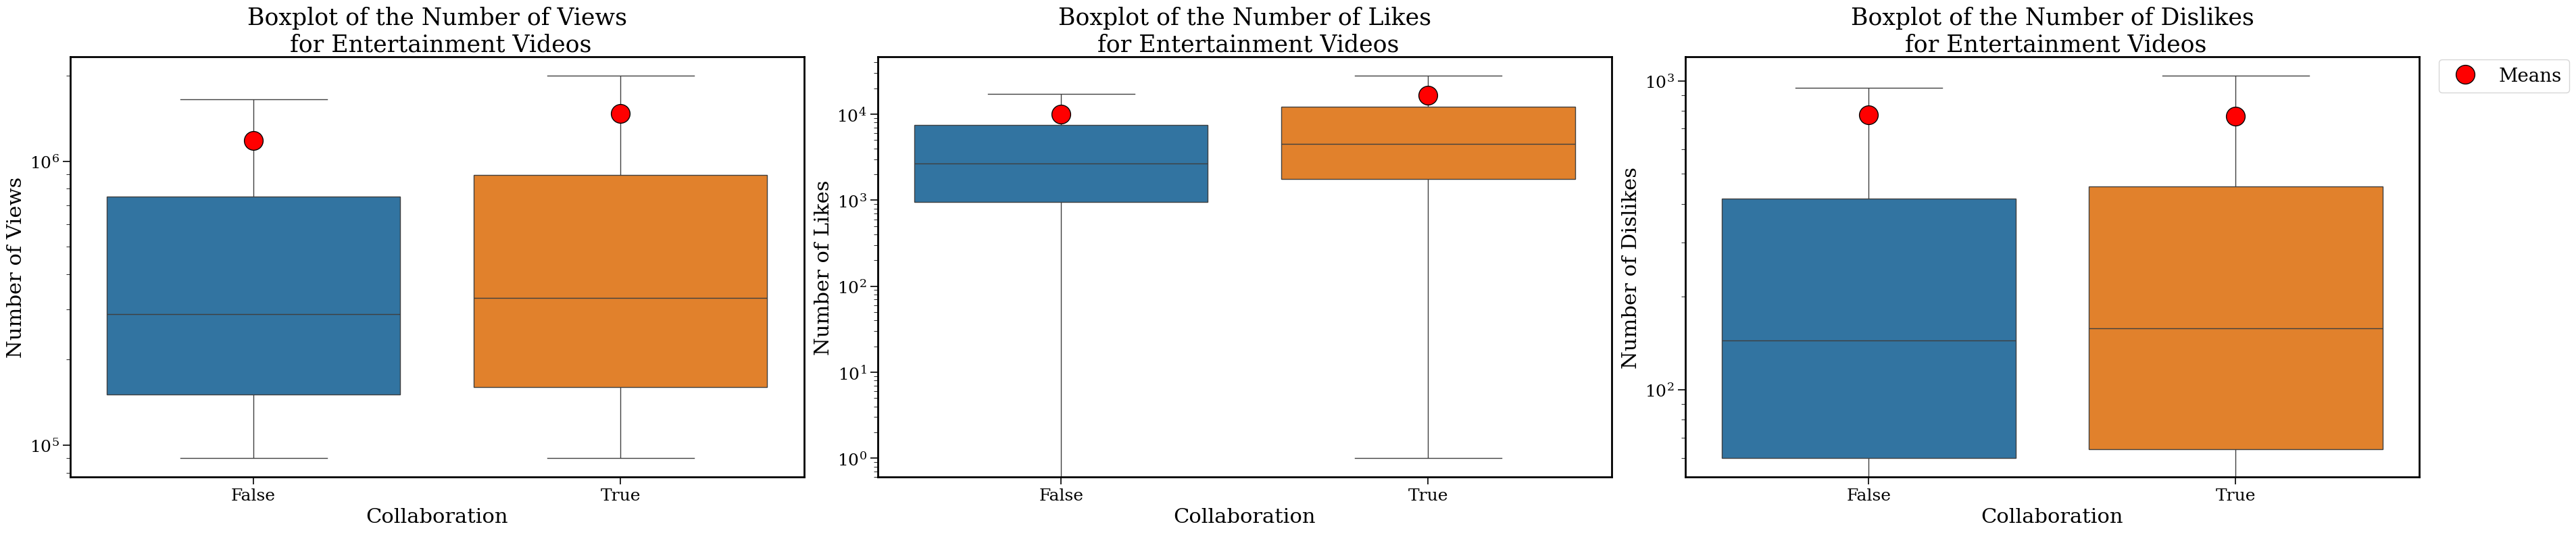

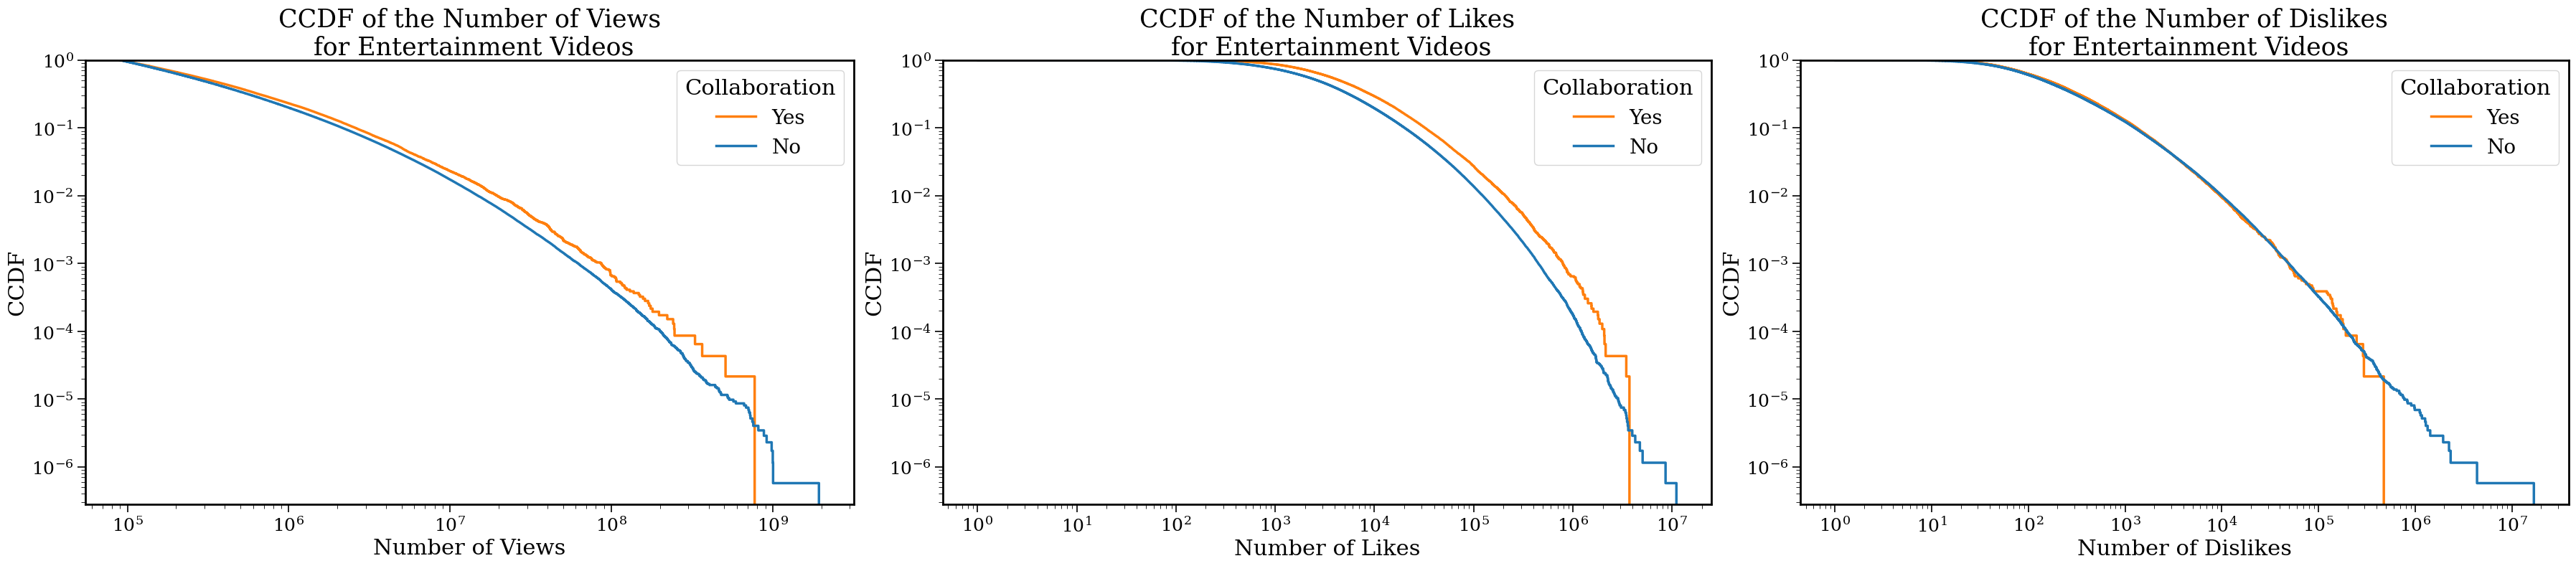

In [22]:
# Compare the different distributions between collaborations and non collaborations for the Entertainment category
collab_utils.plot_comparison_collab_and_non_collab(
    data=top_p_entertainment,
    category="Entertainment",
    columns=columns,
    x_logs=x_logs,
    y_logs=y_logs,
    custom_labels=custom_labels,
    save=True,
)

In [23]:
collab_utils.compare_means_collab_non_collab(top_p_entertainment, columns, custom_labels)

╒═════════════════════════╤══════════════════╤══════════════════════╤════════════════╕
│ Metric                  │ Collaborations   │ Non-Collaborations   │   Ratio (C/NC) │
╞═════════════════════════╪══════════════════╪══════════════════════╪════════════════╡
│ Mean Number of Views    │ 1,471,830.73     │ 1,181,247.34         │           1.25 │
├─────────────────────────┼──────────────────┼──────────────────────┼────────────────┤
│ Mean Number of Likes    │ 16,580.74        │ 10,034.68            │           1.65 │
├─────────────────────────┼──────────────────┼──────────────────────┼────────────────┤
│ Mean Number of Dislikes │ 768.05           │ 774.44               │           0.99 │
╘═════════════════════════╧══════════════════╧══════════════════════╧════════════════╛


In [24]:
collab_utils.test_distributions(top_p_entertainment, columns, custom_labels)

╒═════════════════════════════════════════╤═════════════╤═══════════╤════════════════╕
│ Test                                    │   Statistic │   P-Value │ Significant?   │
╞═════════════════════════════════════════╪═════════════╪═══════════╪════════════════╡
│ Mann-Whitney U (Number of Views)        │    4.24e+10 │  5.68e-90 │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Kolmogorov-Smirnov (Number of Views)    │    0.0422   │  3.34e-70 │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Cramér-von Mises (Number of Views)      │   40.12     │  0        │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Mann-Whitney U (Number of Likes)        │    4.85e+10 │  0        │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Kolmogorov-Smirnov (Number of Likes)    │

## Collaboration-Ratio Based Analysis

In [ ]:
# Create a file containing the number of collaborations for each channel
# process_collab_count(data_file='data/yt_metadata.jsonl.gz, output_path='data/collab_counts.jsonl.gz')

In [ ]:
# Create a file containing the collaboration ratio of each channel
# collab_utils.process_collab_ratio(collab_count_filepath='data/collab_counts.jsonl.gz',
#                                   video_count_filepath='data/video_counts.jsonl.gz',
#                                   output_path='data/collab_ratio.jsonl.gz')

In [33]:
df_collab_ratio = pd.read_json("data/collab_ratio.jsonl.gz", lines=True, compression="gzip")

### Collaboration Ratio Distribution for channels that have at least one video in the top $p$ videos dataframe

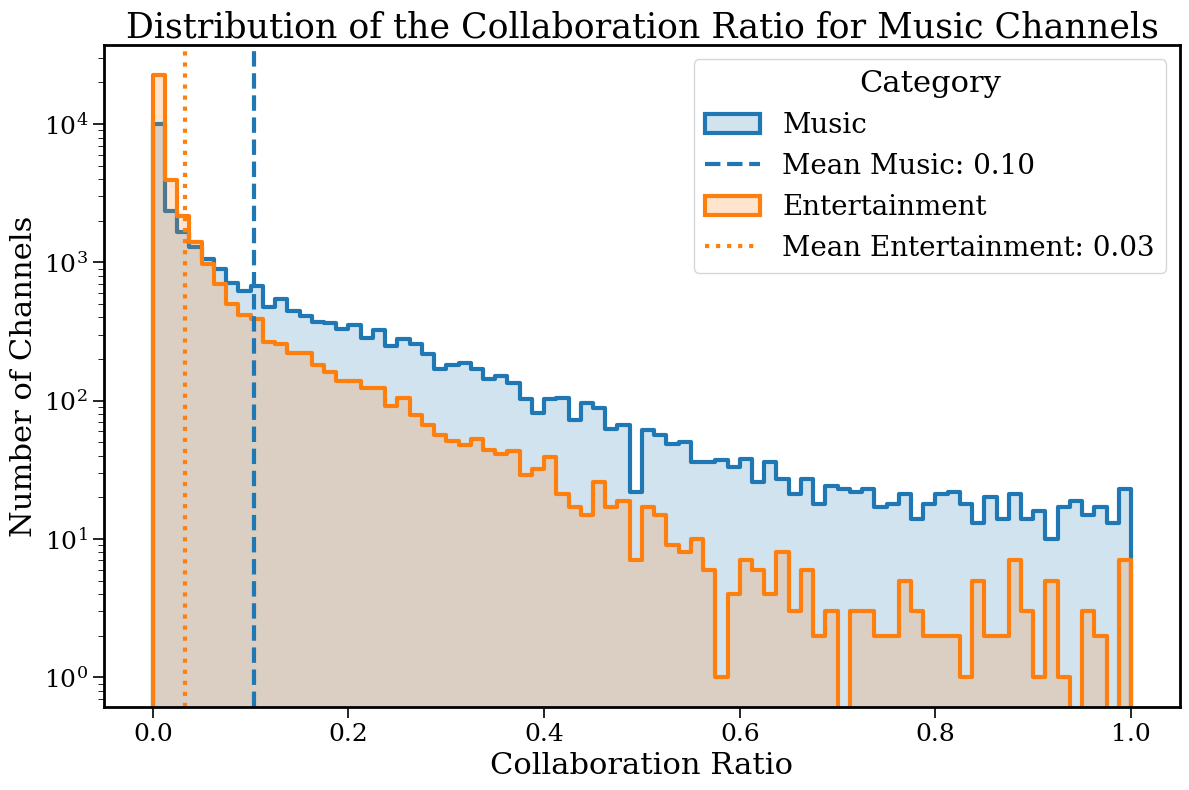

In [85]:
collab_utils.plot_collab_ratio_distribution(top_p_music, top_p_entertainment, df_collab_ratio, p=0.95, show_means=True,
                                            save=True, kind="hist")

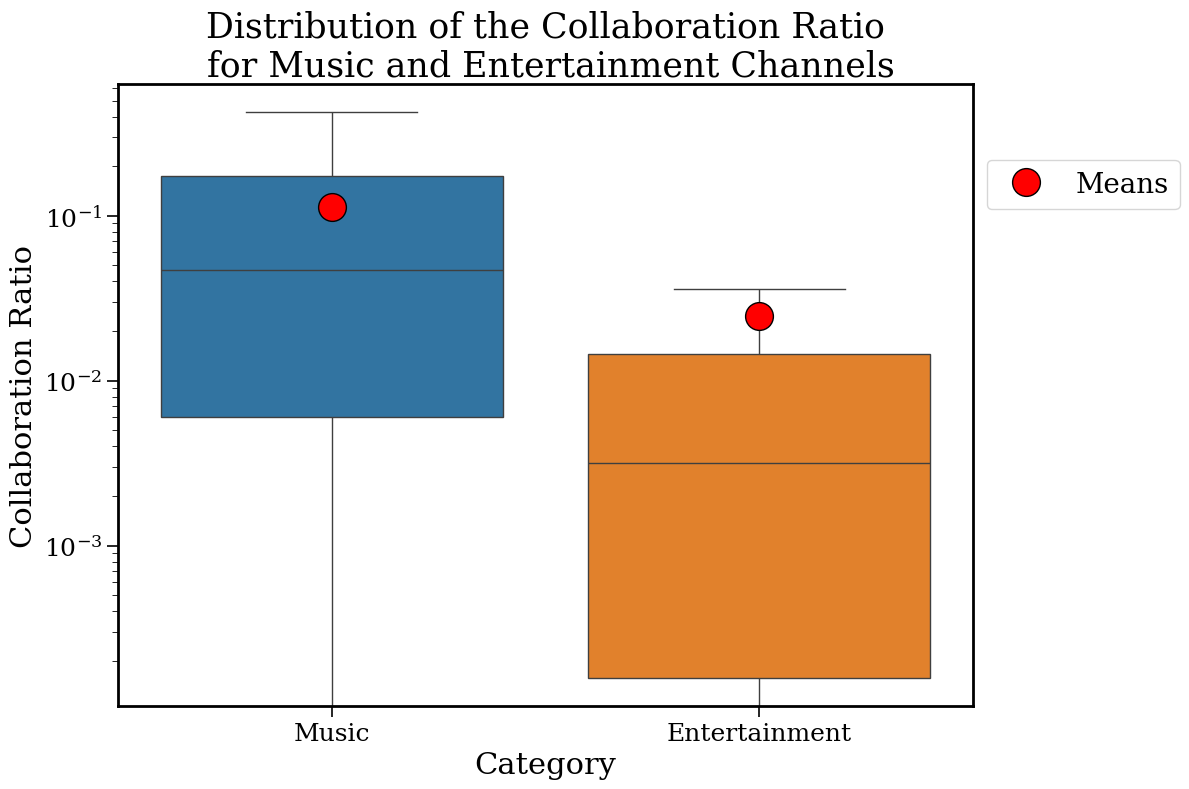

In [86]:
collab_utils.plot_collab_ratio_distribution(top_p_music, top_p_entertainment, df_collab_ratio, p=0.95, show_means=True,
                                            save=True, kind="boxplot")

#### Collaboration Ratio Distribution for Channels that Weight the Most and Comparison with other Channels

In [87]:
# Load the channels data
df_channels = pd.read_csv("data/channels.tsv.gz", sep="\t", compression="gzip").rename(columns={'channel': 'channel_id'})

# Sort Music and Entertainment Channels by their subscriber count
df_music_channels = df_channels[df_channels["category_cc"] == "Music"].sort_values(by='subscribers_cc',ascending=False).reset_index(drop=True)
df_entertainment_channels = df_channels[df_channels["category_cc"] == "Entertainment"].sort_values(by='subscribers_cc',ascending=False).reset_index(drop=True)

In [88]:
# Keep the top p% and the bottom (1-p)% of channels based on the number of subscribers
p = 0.6

# Music
top_p_music_channels = collab_utils.filter_channels_by_proportion(df_music_channels, p_threshold=p)
bottom_p_music_channels = collab_utils.filter_channels_by_proportion(df_music_channels, p_threshold=p, top=False)

# Entertainment
top_p_entertainment_channels = collab_utils.filter_channels_by_proportion(df_entertainment_channels, p_threshold=p)
bottom_p_entertainment_channels = collab_utils.filter_channels_by_proportion(df_entertainment_channels, p_threshold=p, top=False)

In [89]:
collab_utils.print_top_channels_stats(df_music_channels, df_entertainment_channels, top_p_music_channels, 
                                      top_p_entertainment_channels, bottom_p_music_channels, bottom_p_entertainment_channels, p)

Results for p = 0.6:

╒═══════════════╤═══════════════════════════════╤════════════════╤═══════════════════╤════════════════╤═══════════════════╕
│ Category      │   Original Number of Channels │   Top Channels │   Bottom Channels │ Top Fraction   │ Bottom Fraction   │
╞═══════════════╪═══════════════════════════════╪════════════════╪═══════════════════╪════════════════╪═══════════════════╡
│ Music         │                         29166 │            984 │             28182 │ 3.37%          │ 96.63%            │
├───────────────┼───────────────────────────────┼────────────────┼───────────────────┼────────────────┼───────────────────┤
│ Entertainment │                         26347 │           1363 │             24984 │ 5.17%          │ 94.83%            │
╘═══════════════╧═══════════════════════════════╧════════════════╧═══════════════════╧════════════════╧═══════════════════╛


Top 60.00% of videos
------------------------------------------------------------------------------
Category        Original Number of Videos      Top Videos           Fraction  
------------------------------------------------------------------------------
Music           29166                          984                  3.37%     
Entertainment   26347                          1363                 5.17%     


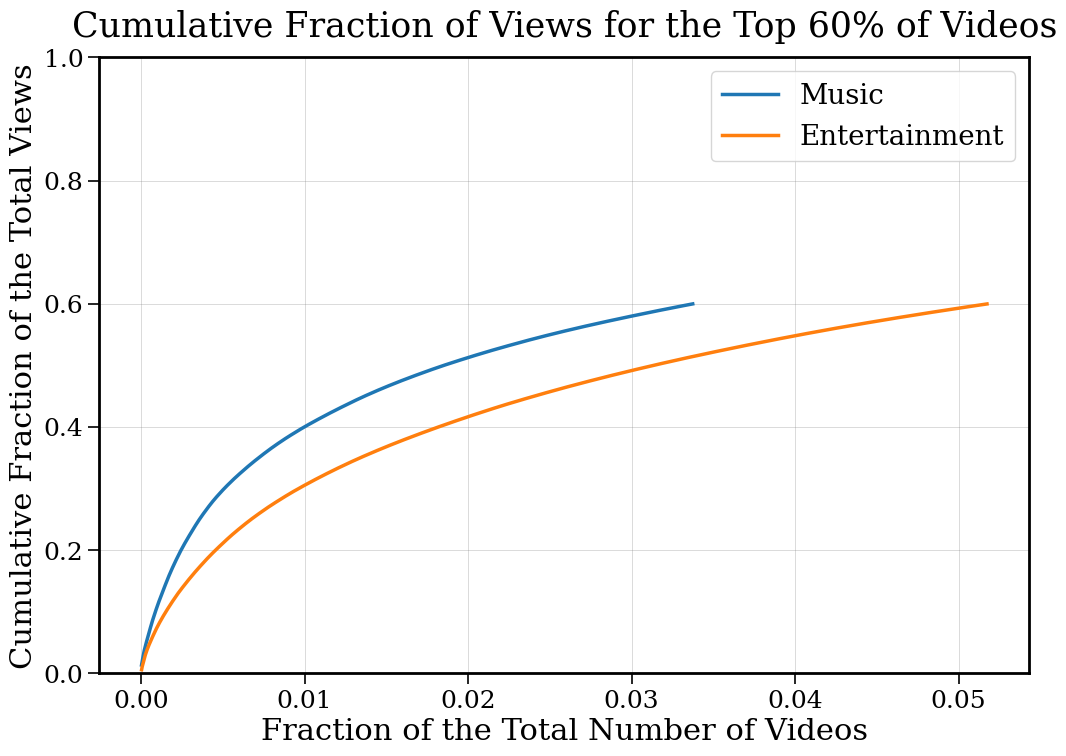

In [90]:
collab_utils.top_p_results(df_music_channels, top_p_music_channels, df_entertainment_channels, top_p_entertainment_channels, p, plot=True)

In [115]:
# Merge the collaboration ration with the top p% of channels
top_p_music_channels = top_p_music_channels.merge(df_collab_ratio, on="channel_id", how="left").dropna()
bottom_p_music_channels = bottom_p_music_channels.merge(df_collab_ratio, on="channel_id", how="left").dropna()

top_p_entertainment_channels = top_p_entertainment_channels.merge(df_collab_ratio, on="channel_id", how="left").dropna()
bottom_p_entertainment_channels = bottom_p_entertainment_channels.merge(df_collab_ratio, on="channel_id", how="left").dropna()

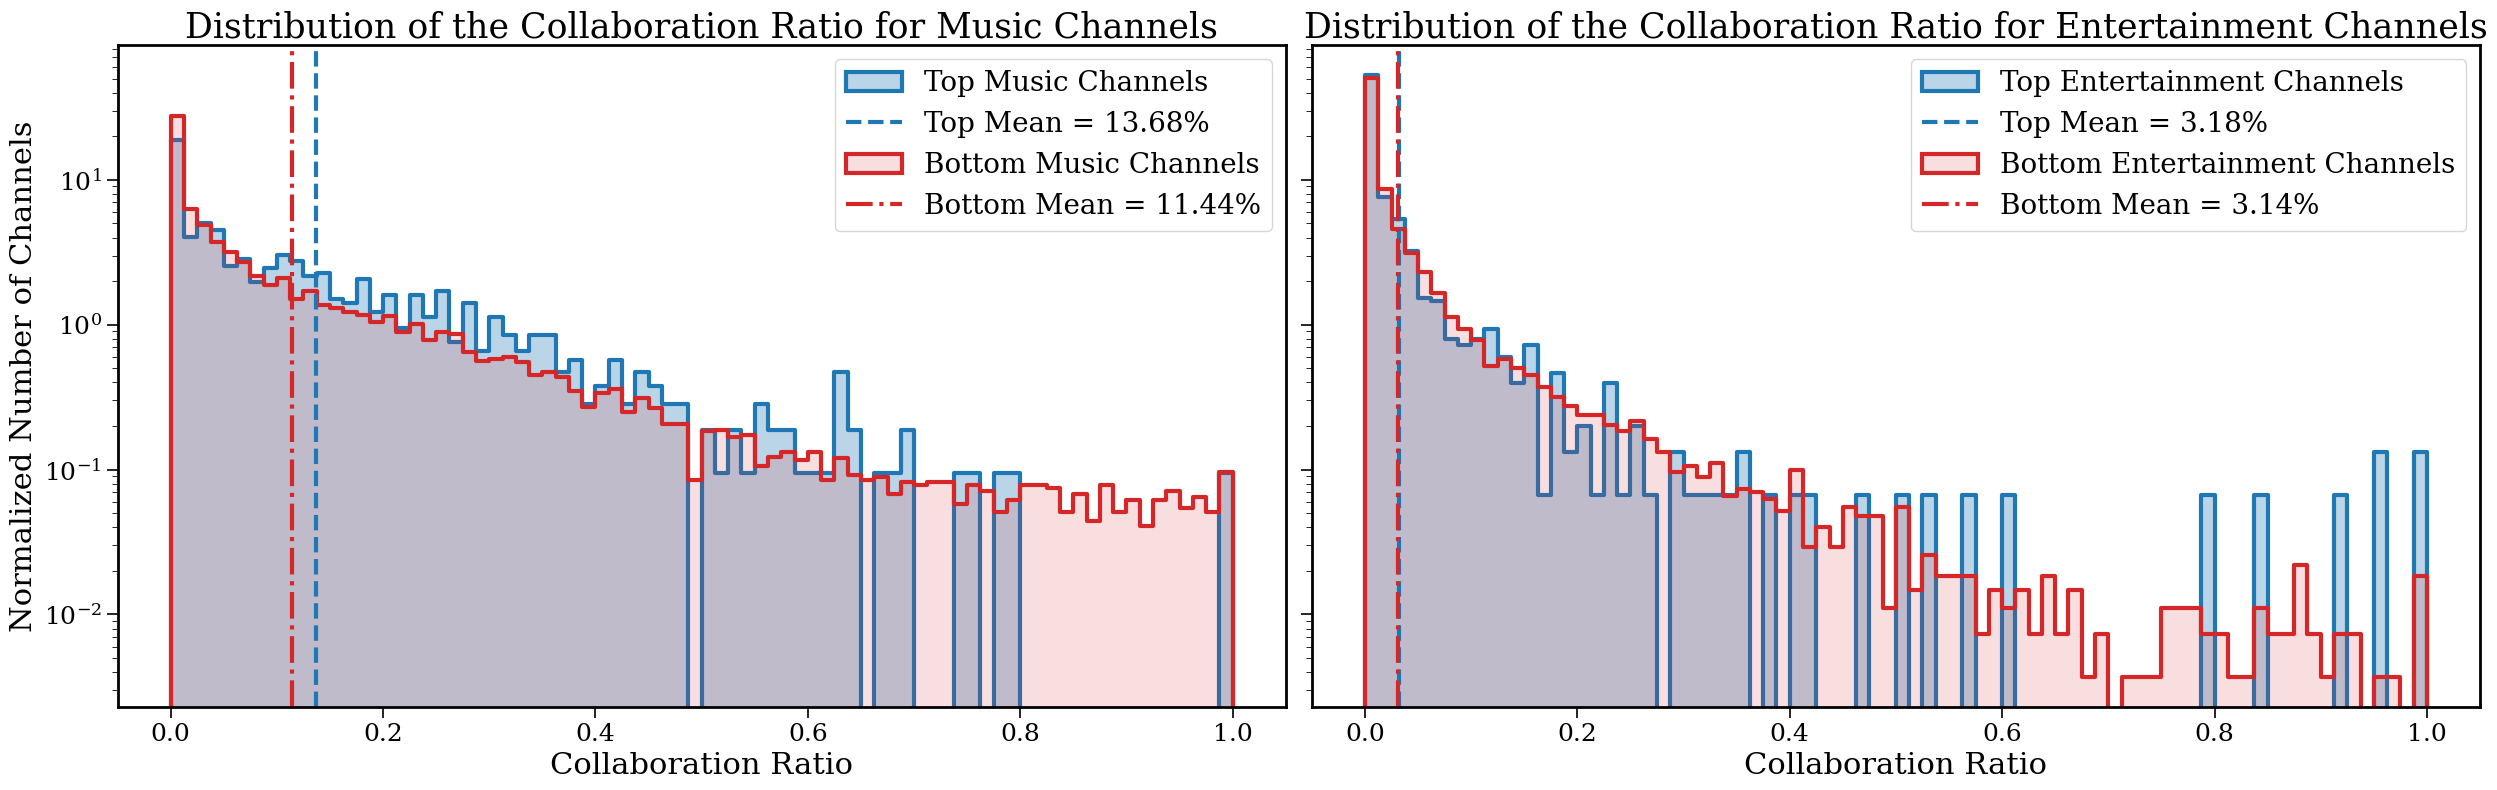

In [116]:
collab_utils.compare_collab_ratio_top_p_channels(top_p_music_channels, bottom_p_music_channels, 
                                                 top_p_entertainment_channels, bottom_p_entertainment_channels, 
                                                 df_collab_ratio, p=p, save=True)

In [118]:
collab_utils.test_distribution_top_vs_bottom(top_data=[top_p_music_channels, top_p_entertainment_channels], 
                                             bottom_data=[bottom_p_music_channels, bottom_p_entertainment_channels],
                                             categories=["Music", "Entertainment"],
                                             columns=["collab_ratio"])

╒═══════════════════════════════════╤═══════════════╤═════════════╤═══════════╤════════════════╕
│ Test                              │ Category      │   Statistic │   P-Value │ Significant?   │
╞═══════════════════════════════════╪═══════════════╪═════════════╪═══════════╪════════════════╡
│ Mann-Whitney U (collab_ratio)     │ Music         │    1.15e+07 │  8.48e-16 │ Yes            │
├───────────────────────────────────┼───────────────┼─────────────┼───────────┼────────────────┤
│ Kolmogorov-Smirnov (collab_ratio) │ Music         │    0.14     │  1.92e-14 │ Yes            │
├───────────────────────────────────┼───────────────┼─────────────┼───────────┼────────────────┤
│ Cramér-von Mises (collab_ratio)   │ Music         │  725        │  1.68e-07 │ Yes            │
├───────────────────────────────────┼───────────────┼─────────────┼───────────┼────────────────┤
│ Mann-Whitney U (collab_ratio)     │ Entertainment │    1.37e+07 │  0.00342  │ Yes            │
├─────────────────────────────